### Topic Modelling - and more - with Gensim!

```
- Gensim
- matplotlib
- spaCy
- pyLDAVis
```


In [1]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now
%matplotlib inline

For this tutorial, we will be using the Lee corpus which is a shortened version of the [Lee Background Corpus](http://www.socsci.uci.edu/~mdlee/lee_pincombe_welsh_document.PDF). The shortened version consists of 300 documents selected from the Australian Broadcasting Corporation's news mail service. It consists of texts of headline stories from around the year 2000-2001. 

In [2]:
test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'
text = open(lee_train_file).read()

In [4]:
print(type(text))
text[0:100]

<class 'str'>


'Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wal'

### Pre-processing data!

In [5]:
from spacy.en import English
nlp = spacy.load("en")

In [6]:
my_stop_words = [u'say', u'\'s', u'Mr', u'be', u'said', u'says', u'saying']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

Voila! With the `English` pipeline, all the heavy lifting has been done. Let's see what went on under the hood.

In [ ]:
def clean(text):
    return (''.join([i if ord(i) < 128 else ' ' for i in text]))
""

In [69]:
doc=nlp(text)
doc[0:100]

Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands.

It seems like nothing, right? But spaCy's internal data structure has done all the work for us. Let's see how we can create our corpus. You can check out what a gensim corpus looks like [here](google.com).

In [13]:
type(doc)

spacy.tokens.doc.Doc

In [17]:
# we add some words to the stop word list
texts, article = [], []
for w in doc:

    # if it's not a stop word or punctuation mark, add it to our article!
    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
        # we add the lematized version of the word
        article.append(w.lemma_)
    # if it's a new line, it means we're onto our next document
    if w.text == '\n':
        texts.append(article)
        article = []

And this is the magic of spaCy - just like that, we've managed to get rid of stopwords, punctauation markers, and added the lemmatized word. There's lot more we can do with spaCy which I would really recommend checking out.

Sometimes topic models make more sense when 'New' and 'York' are treated as 'New_York' - we can do this by creating a bigram model and modifying our corpus accordingly.

Input to gensim is list of lists

In [32]:
print(type(texts))
print("Number of docs",len(texts))

<class 'list'>
Number of docs 299


In [35]:
bigram = gensim.models.Phrases(texts)
bigram

In [37]:
texts = [bigram[line] for line in texts]
texts[0][0:5]

['hundred', 'people', 'force', 'vacate', 'home']

In [55]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
print("Corpus is a BOW represenetation(Word ID, count):",corpus[0][0:5])
print(dictionary)
print(type(dictionary))

Corpus is a BOW represenetation(Word ID, count): [(0, 1), (1, 2), (2, 3), (3, 1), (4, 3)]
Dictionary(5601 unique tokens: ['hundred', 'people', 'force', 'vacate', 'home']...)
<class 'gensim.corpora.dictionary.Dictionary'>


### LSI

LSI stands for Latent Semantic Indeixing - it is a popular information retreival method which works by decomposing the original matrix of words to maintain key topics. Gensim's implementation uses an SVD.

Each topic= Distribution of Words:

Example of Topic:
* Palestine Conflict
* Aftghanistan war
    
Each Document= Distribution of Topics

In [56]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [57]:
print(type(lsimodel))
print(lsimodel.num_terms)

<class 'gensim.models.lsimodel.LsiModel'>
5601


In [64]:
(lsimodel.show_topics(num_topics=5))  # Showing only the top 5 topics

[(0,
  '-0.216*"israeli" + -0.198*"arafat" + -0.185*"force" + -0.175*"palestinian" + -0.151*"kill" + -0.147*"people" + -0.146*"attack" + -0.134*"government" + -0.130*"official" + -0.123*"australian"'),
 (1,
  '-0.324*"israeli" + -0.323*"arafat" + -0.285*"palestinian" + -0.169*"israel" + 0.162*"australia" + 0.159*"australian" + -0.149*"sharon" + 0.145*"afghanistan" + -0.140*"hamas" + 0.109*"day"'),
 (2,
  '0.286*"afghanistan" + 0.263*"force" + 0.173*"bin_laden" + -0.170*"good" + 0.162*"pakistan" + -0.155*"test" + -0.143*"win" + 0.138*"afghan" + -0.132*"australia" + -0.130*"fire"'),
 (3,
  '0.416*"fire" + 0.285*"area" + 0.222*"sydney" + 0.194*"firefighter" + -0.177*"australia" + 0.172*"north" + 0.161*"wind" + 0.142*"new_south_wales" + -0.125*"good" + 0.124*"south"'),
 (4,
  '0.253*"company" + 0.225*"union" + -0.186*"test" + 0.182*"qantas" + 0.141*"australian" + -0.131*"match" + -0.129*"good" + 0.127*"government" + -0.123*"day" + -0.123*"win"')]

### HDP

HDP, the Hierarchical Dirichlet process is an unsupervised topic model which figures out the number of topics on it's own.

In [59]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [60]:
len(hdpmodel.show_topics())

20

### LDA

LDA, or Latent Dirichlet Allocation is arguably the most famous topic modelling algorithm out there. Out here we create a simple topic model with 10 topics.

In [61]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [62]:
ldamodel.show_topics()

[(0,
  '0.007*"israeli" + 0.007*"australian" + 0.006*"palestinian" + 0.006*"official" + 0.005*"man" + 0.005*"australia" + 0.005*"people" + 0.004*"hamas" + 0.004*"day" + 0.004*"attack"'),
 (1,
  '0.006*"australian" + 0.006*"australia" + 0.005*"year" + 0.004*"people" + 0.004*"report" + 0.004*"area" + 0.004*"day" + 0.003*"know" + 0.003*"tell" + 0.003*"today"'),
 (2,
  '0.005*"government" + 0.004*"australia" + 0.004*"force" + 0.004*"australian" + 0.004*"day" + 0.003*"afghanistan" + 0.003*"taliban" + 0.003*"man" + 0.003*"people" + 0.003*"take"'),
 (3,
  '0.005*"child" + 0.004*"year" + 0.004*"union" + 0.004*"president" + 0.004*"man" + 0.003*"people" + 0.003*"company" + 0.003*"virus" + 0.003*"attack" + 0.003*"come"'),
 (4,
  '0.007*"fire" + 0.005*"force" + 0.004*"new" + 0.004*"area" + 0.004*"group" + 0.003*"believe" + 0.003*"good" + 0.003*"australian" + 0.003*"australia" + 0.003*"year"'),
 (5,
  '0.005*"people" + 0.004*"union" + 0.004*"work" + 0.004*"israeli" + 0.004*"australia" + 0.004*"aust

### pyLDAvis 

Thanks to pyLDAvis, we can visualise our topic models in a really handy way. All we need to do is enable our notebook and prepare the object.

In [63]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      18.459084        1       1 -0.011513 -0.010455
0      11.799552        1       2 -0.083046 -0.000047
1      11.564665        1       3  0.027463 -0.029433
9      10.416249        1       4  0.001495  0.013739
5       9.686570        1       5 -0.013242  0.043504
6       9.193210        1       6  0.033812 -0.019900
4       8.252109        1       7  0.001618 -0.028124
3       7.792368        1       8  0.035623  0.053959
7       6.569870        1       9  0.006127  0.016696
8       6.266323        1      10  0.001664 -0.039940, topic_info=     Category        Freq              Term       Total  loglift  logprob
term                                                                     
53    Default   68.000000              fire   68.000000  30.0000  30.0000
839   Default   76.000000           israeli   76.000000  29.0000  29.0000
713   Default   54.000000             union   54.000000  28.0000  28.0000
5150  Default    8.000000             virus    8.000000  27.0000  27.0000
2012  Default   42.000000             child   42.000000  26.0000  26.0000
335   Default   39.000000             power   39.000000  25.0000  25.0000
845   Default   36.000000             hamas   36.000000  24.0000  24.0000
2124  Default   56.000000            arafat   56.000000  23.0000  23.0000
816   Default   61.000000       palestinian   61.000000  22.0000  22.0000
861   Default   22.000000              boat   22.000000  21.0000  21.0000
178   Default   15.000000              road   15.000000  20.0000  20.0000
871   Default  121.000000        australian  121.000000  19.0000  19.0000
2306  Default   31.000000            qantas   31.000000  18.0000  18.0000
228   Default   24.000000               job   24.000000  17.0000  17.0000
186   Default   92.000000              year   92.000000  16.0000  16.0000
704   Default   28.000000             party   28.000000  15.0000  15.0000
206   Default   43.000000         president   43.000000  14.0000  14.0000
2077  Default   24.000000           economy   24.000000  13.0000  13.0000
634   Default   64.000000          official   64.000000  12.0000  12.0000
128   Default   58.000000            police   58.000000  11.0000  11.0000
2     Default   97.000000             force   97.000000  10.0000  10.0000
1983  Default   10.000000           project   10.000000   9.0000   9.0000
103   Default   23.000000       firefighter   23.000000   8.0000   8.0000
272   Default   52.000000              work   52.000000   7.0000   7.0000
2237  Default   14.000000  governor_general   14.000000   6.0000   6.0000
5153  Default    5.000000              user    5.000000   5.0000   5.0000
754   Default   14.000000           dispute   14.000000   4.0000   4.0000
5149  Default    5.000000          computer    5.000000   3.0000   3.0000
1740  Default   37.000000            israel   37.000000   2.0000   2.0000
868   Default   25.000000             metre   25.000000   1.0000   1.0000
...       ...         ...               ...         ...      ...      ...
871   Topic10    8.266885        australian  121.689635   0.0808  -5.3806
896   Topic10    4.576580              test   43.627085   0.5153  -5.9719
605   Topic10    2.655040              tree   15.391378   1.0126  -6.5164
231   Topic10    6.924690               day   99.201352   0.1079  -5.5577
385   Topic10    4.424551              lead   42.739664   0.5020  -6.0057
537   Topic10    3.324050           control   25.006585   0.7520  -6.2916
413   Topic10    5.082591              good   60.399418   0.2948  -5.8670
10    Topic10    5.169350             today   65.618161   0.2289  -5.8501
185   Topic10    5.105891              time   64.870652   0.2280  -5.8624
308   Topic10    6.488035         australia  117.108634  -0.1232  -5.6229
2277  Topic10    4.888898           company   62.123369   0.2278  -5.9059
1152  Topic10    3.529208              head   30.1068

### Topic Coherence

In [65]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [66]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

In [67]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

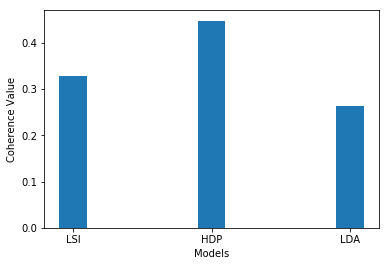

In [68]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])